In [1]:
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
     
import torch as t
from transformer_lens.utils import to_numpy
import plotly.express as px
import pprint
import pandas as pd
import matplotlib.pyplot as plt


import importlib

def reload_fuctions():
    '''
    Reloads the functions from the utils package. 
    This is useful when you are working on the functions 
    and want to see the changes without restarting the kernel.'''
    import utils

    importlib.reload(utils.data)
    importlib.reload(utils.model)
    importlib.reload(utils.plotting)

    globals().update({name: getattr(utils.data, name) for name in dir(utils.data)})
    globals().update({name: getattr(utils.model, name) for name in dir(utils.model)})
    globals().update({name: getattr(utils.plotting, name) for name in dir(utils.plotting)})

    

from utils.data import *
from utils.model import *
from utils.plotting import *


plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'bwr'
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

# Tracr sorting model
It translates the inputs into unique keys and sort them using unique sort. which is implemented like this:
```python

```

In [2]:
input_size = 10
vocab = {*range(input_size)}
program = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=input_size, min_key=0)

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=input_size,
      compiler_bos="bos",
      mlp_exactness=100)

INPUT_ENCODER = assembled_model.input_encoder
OUTPUT_ENCODER = assembled_model.output_encoder

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Tracr model Config
After compling we see that the model has 2 layers, which is less that the maximum sequence length, meaning that the model is able to sort sequences longer than it's model length

In [3]:
pprint.pprint(assembled_model.model_config)

TransformerConfig(num_heads=1,
                  num_layers=3,
                  key_size=12,
                  mlp_hidden_size=100,
                  dropout_rate=0.0,
                  activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x7fcf8031d5d0>,
                  layer_norm=False,
                  causal=False)


In [3]:
reload_fuctions()
TRAIN = False

cfg = cfg_from_tracr(assembled_model)
model = HookedTransformer(cfg)
model_mid_decay = HookedTransformer(cfg)
model_high_decay = HookedTransformer(cfg)
tr_model = HookedTransformer(cfg)
tr_model = load_tracr_weights(tr_model, assembled_model, cfg)
criterion = transformers_cross_entropy
decays = [0, 0.0001, 0.001]
labels = ['no_decay', 'mid_decay', 'high_decay']

models =[model, model_mid_decay, model_high_decay]
name_dict = {lamb: label for lamb, label in zip(decays, labels)} 
lr=.001
m_losses = []
m_accuracies = []
m_metrics = []

if TRAIN:
    epochs = 300
    batch_size = 256
    for penalty in [l1_pentaly_activation]:
        for lamb,m in zip(decays, models):
            optimizer = t.optim.AdamW(m.parameters(), lr=lr)

            

            
            
            save_path = f'models/sort_{name_dict[lamb]}_l1_activation.pth' 
            print(save_path)

            losses, accuracy, metrics = train_model(m, optimizer, criterion, penalty(lamb), train_loader, epochs, batch_size, input_size, len(vocab), test_benchmarks, save_path)
            m_losses.append(losses)
            m_accuracies.append(accuracy)
            m_metrics.append(metrics)
        

save_paths = [f'models/sort_{name_dict[lamb]}_l1_activation.pth' for lamb in decays]

for m, save_path in zip([model, model_mid_decay, model_high_decay], save_paths):
    print(save_path)
    m.load_state_dict(t.load(save_path), strict=True)

models/sort_no_decay_l1_activation.pth
models/sort_mid_decay_l1_activation.pth
models/sort_high_decay_l1_activation.pth


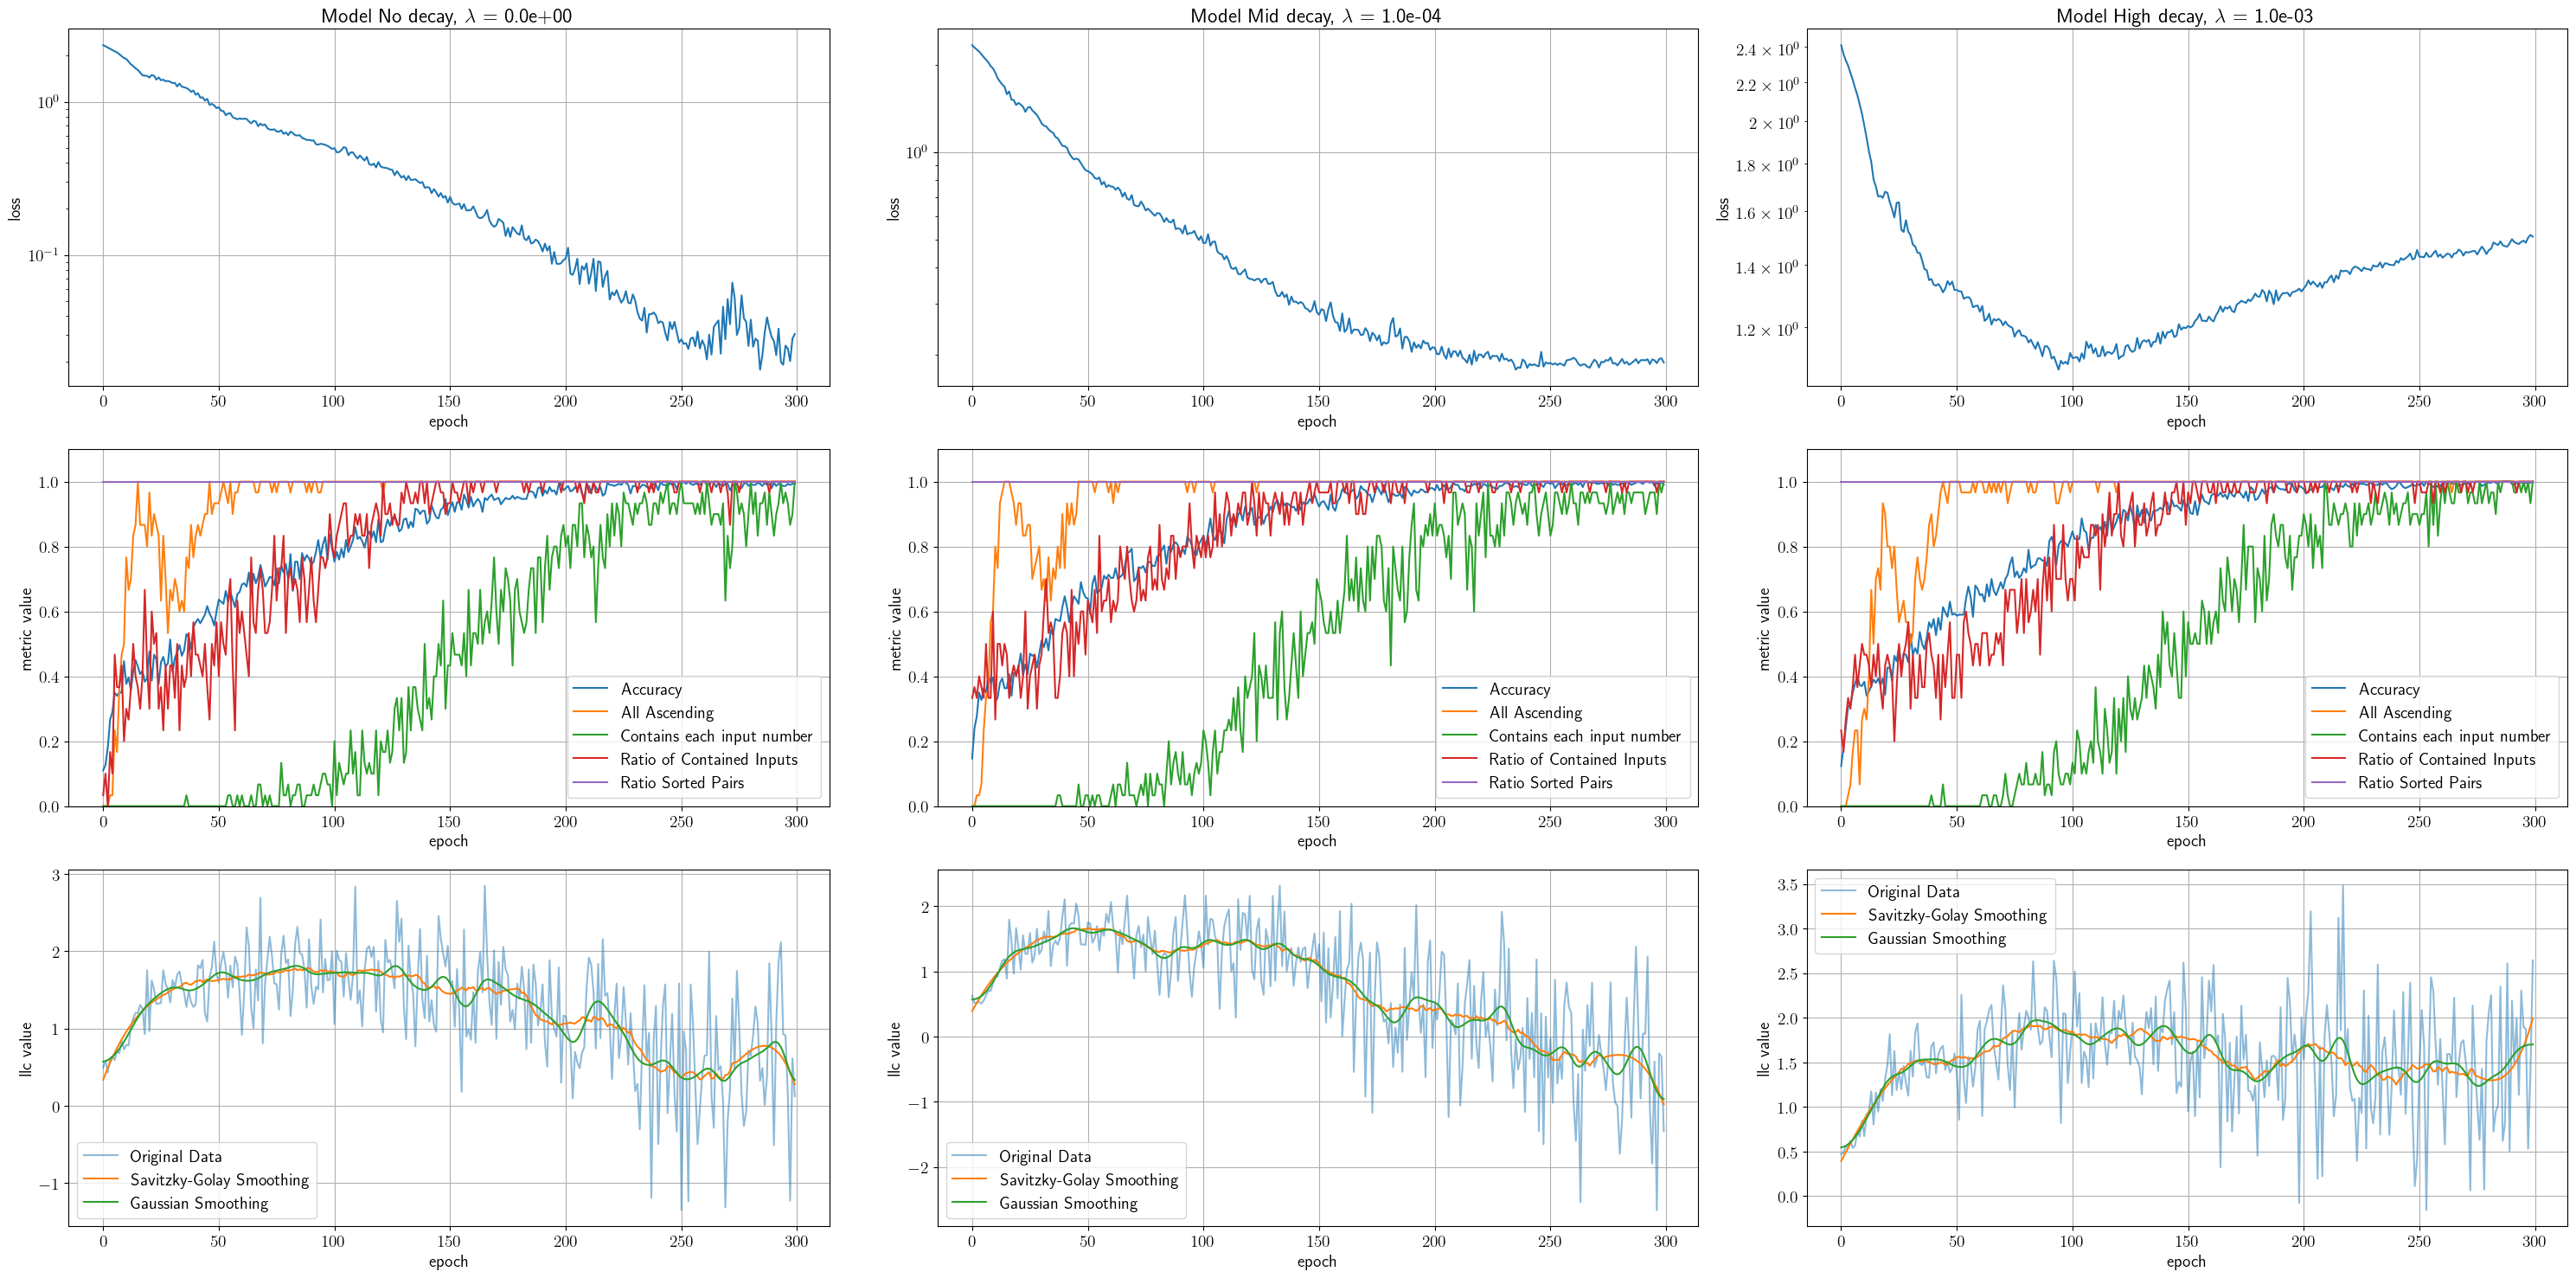

In [4]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

metric_labels = ['Accuracy', 'All Ascending', 'Contains each input number', 'Ratio of Contained Inputs', 'Ratio Sorted Pairs']

if TRAIN:
    data = np.empty((len(decays), 1+len(metric_labels), epochs))
    data[:, 0, :] = np.array(m_losses)
    data[:, 1, :] = np.array(m_accuracies)
    data[:, 2:, :] = np.array(m_metrics)
    np.save('data/metrics.npy', data)
else:
    data = np.load('data/metrics.npy')

llc_vals = pd.read_csv('data/llc_values.csv')
llc_vals['decay'] = llc_vals['model'].apply(lambda x: x.split('_')[1])
llc_vals['epoch'] = llc_vals['model'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))

# plot llc values for difference decay in the same figure
llc = [ llc_vals[llc_vals['decay'] == 'no'],
        llc_vals[llc_vals['decay'] == 'mid'], 
        llc_vals[llc_vals['decay'] == 'high']]


fig, axes = plt.subplots(3, 3, figsize=(30,15))
# For each model make 3 plots, one containing, loss, one with accuracy and the metrics and the final one with the llc values
for m in range(3):
    axes[0, m].set_title(f"Model {name_dict[decays[m]].replace('_', ' ').capitalize()}, $\lambda$ = {decays[m]:.1e}")
    axes[0, m].plot(data[m, 0, :])
    axes[0, m].set_xlabel('epoch')
    axes[0, m].set_ylabel('loss')
    axes[0, m].set_yscale('log')
    axes[0, m].grid(True)

    for i, metric in enumerate(metric_labels):
        axes[1, m].plot(data[m, 1+i, :], label=metric)
    axes[1, m].set_xlabel('epoch')
    axes[1, m].set_ylabel('metric value')
    axes[1, m].legend()
    axes[1, m].set_ylim(0, 1.1)
    axes[1, m].grid(True)

    axes[2, m].set_xlabel('epoch')
    axes[2, m].set_ylabel('llc value')
    axes[2, m].plot(llc[m]['epoch'], llc[m]['llc_value'], alpha=.5, label='Original Data')
    axes[2, m].plot(llc[m]['epoch'], savgol_filter(llc[m]['llc_value'], 51, 3), label='Savitzky-Golay Smoothing')
    axes[2, m].plot(llc[m]['epoch'], gaussian_filter1d(llc[m]['llc_value'], 4), label='Gaussian Smoothing')
    axes[2, m].legend()
    axes[2, m].grid(True)

plt.tight_layout()
plt.show()

- How sparse can the models get
  - Training tracr with very high sparsity
- activation patching
- LLC try but sign might not be important
- 

In [22]:
TRAIN_COMPRESSED = False
reload_fuctions()
compressed_model = deepcopy(model)
compressed_model.compression = CompressionHook(model.cfg.d_model, 1.3)
pre_training_weight = compressed_model.compression.fc_compress.weight.clone()
losses = []
metrics = []
accuracies = []

if TRAIN_COMPRESSED:
    epochs = 300
    batch_size = 4096
    optimizer = t.optim.AdamW(compressed_model.compression.fc_compress.parameters(), lr=1e-3)
    save_path = f'models/sort_mini_compessed.pth' 

    loss, accuracy, bench = train_model(compressed_model, optimizer, criterion, no_pentaly(1), train_loader, epochs, batch_size, input_size, len(vocab), test_benchmarks, save_path)
    losses.extend(loss)
    metrics.extend(bench)
    accuracies.extend(accuracy)


post_training_weight = compressed_model.compression.fc_compress.weight.clone()

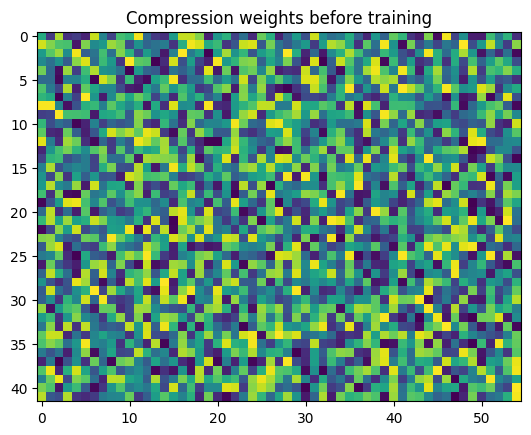

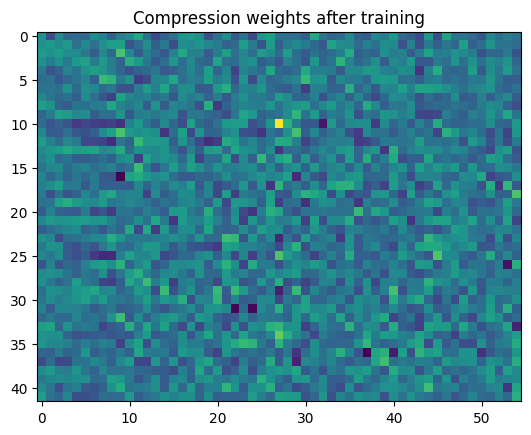

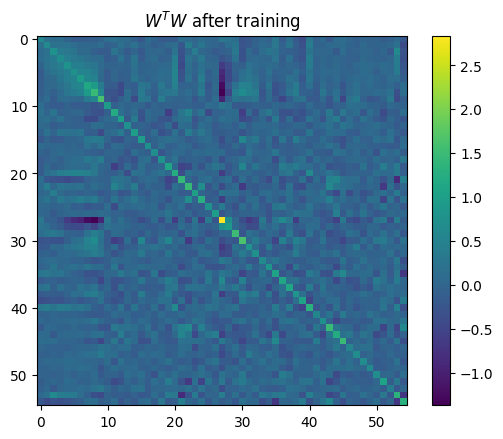

In [265]:
diff_weights = pre_training_weight - post_training_weight
plt.imshow(to_numpy(pre_training_weight))
plt.title("Compression weights before training")
plt.show()
plt.imshow(to_numpy(post_training_weight))
plt.title("Compression weights after training")
plt.show()
plt.imshow(to_numpy(post_training_weight.T) @ to_numpy(post_training_weight))
plt.title("$W^T W$ after training")
plt.colorbar()
plt.show()

In [13]:
reload_fuctions()

models = [model, model_mid_decay, model_high_decay, assembled_model]
model_names = ['Model:\t\t', 'Model 0.01 decay:', 'Model 0.1 decay:','Tracr model:\t']
input_size = 10
x,y = generate_data(1, len(vocab), input_size)
x = t.arange(input_size).unsqueeze(0).flip(1)
y = x.clone()
print('Data in:\t\t', x.squeeze().tolist())
print('Data out:\t\t', y.squeeze().tolist())

for i, mod in enumerate(models):
    pred = prompt(mod, x)
    print(f'{model_names[i]}\t', pred)

Data in:		 [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Data out:		 [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Model:			 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Model 0.01 decay:	 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Model 0.1 decay:	 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Tracr model:		 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [14]:
reload_fuctions()
assembled_logits, assembled_cache = run_with_activations(assembled_model, x)
trained_logits, trained_cache = run_with_activations(model, x)
trained_mid_decay_logits, trained_mid_decay_cache = run_with_activations(model_mid_decay, x)
trained_high_decay_logits, trained_high_decay_cache = run_with_activations(model_high_decay, x)
tracr_logits, tracr_cache = run_with_activations(tr_model, x, INPUT_ENCODER)

## Tracr Transformer output reference:
| Activation      | Dimension                          |
|-----------------|------------------------------------|
| layer_outputs   | [Batch, Sequence_Size, d_embedding]|
| residuals       | [Batch, Sequence_Size, d_embedding]|
| attn_logits     | [Batch, n_heads, Sequence_Size, Sequence_Size]|
| output          | [Batch, Sequence_Size, d_embedding]|
| input_embeddings| [Batch, Sequence_size, d_embedding]|

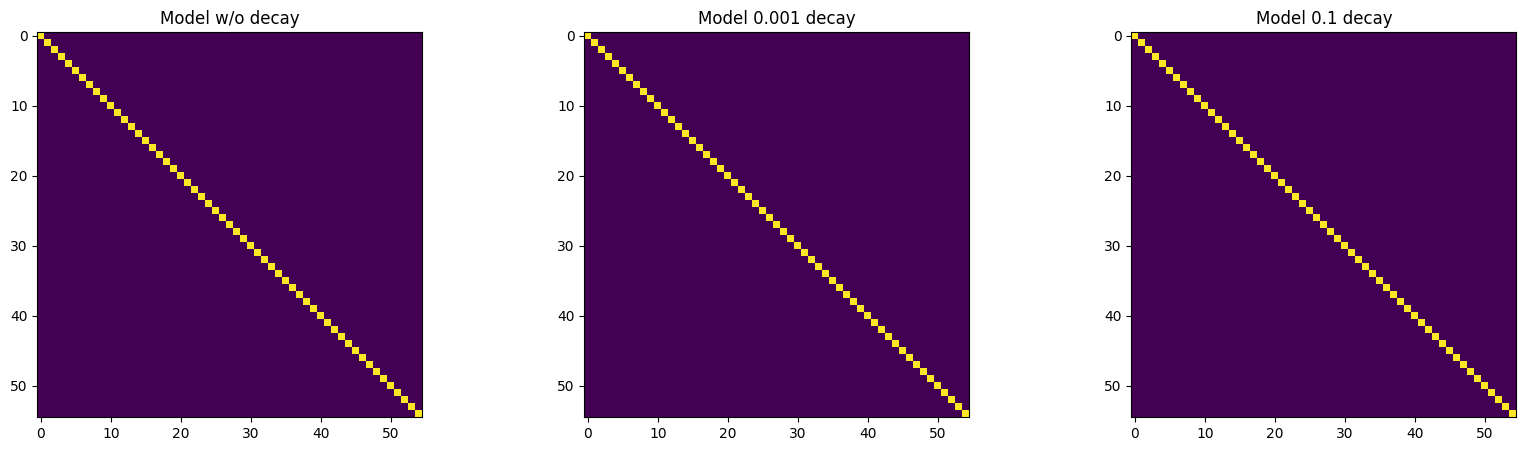

In [76]:
reload_fuctions()
compression_hooks = [m.compression.weight for m in [model, model_mid_decay, model_high_decay]]
compression_hook_names = ['Model w/o decay', 'Model 0.001 decay', 'Model 0.1 decay']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, hook in enumerate(compression_hooks):
    axs[i].imshow(to_numpy(hook))
    axs[i].set_title(compression_hook_names[i])

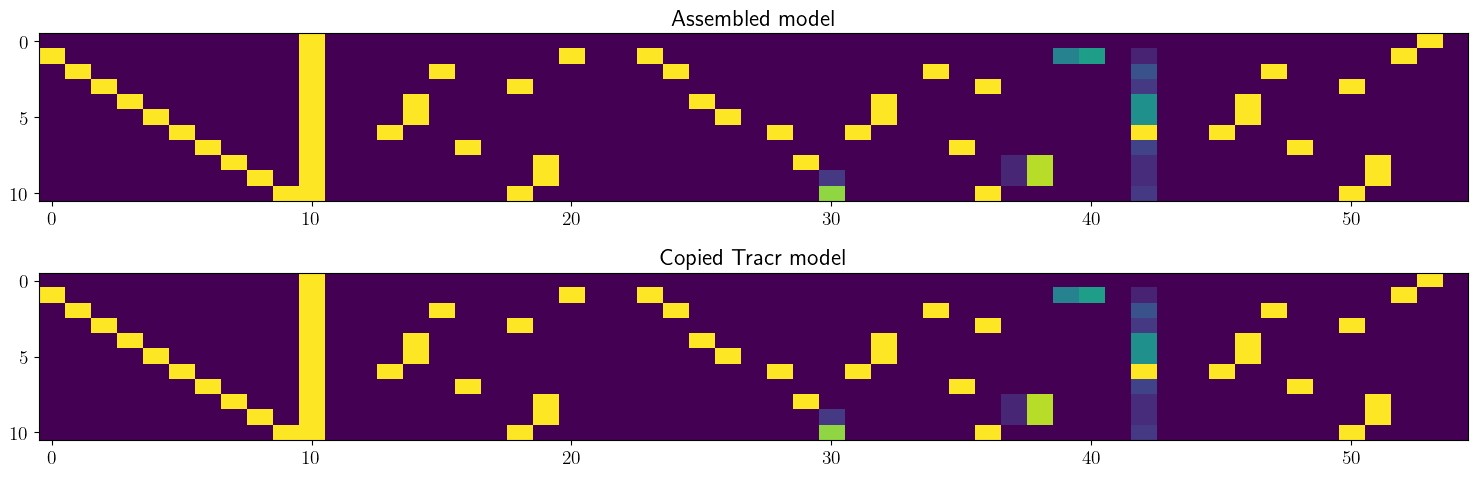

In [9]:
copied_out = to_numpy(tracr_cache['blocks.2.hook_resid_post']).squeeze()
assembled_out = assembled_cache.transformer_output.squeeze()

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].imshow(assembled_out, aspect='auto')
ax[0].set_title('Assembled model')
ax[1].imshow(copied_out, aspect='auto')
ax[1].set_title('Copied Tracr model')
plt.tight_layout()
plt.show()

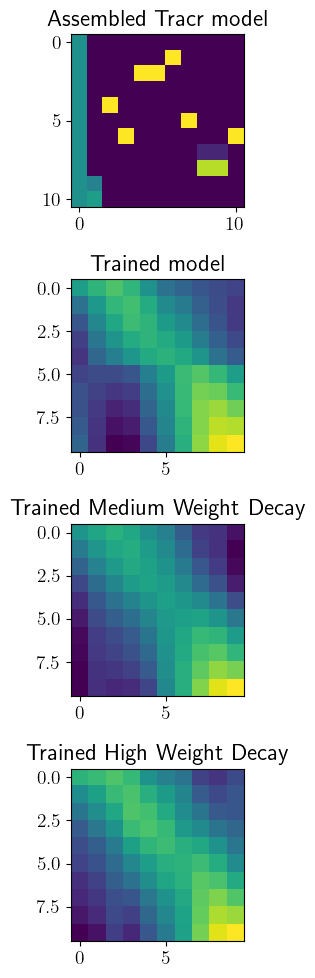

In [10]:
reload_fuctions()
logits = [
    np.array(assembled_logits[-1]),
    to_numpy(trained_logits),
    to_numpy(trained_mid_decay_logits),
    to_numpy(trained_high_decay_logits),
]

plot_activations(["Assembled Tracr model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay"], *logits)

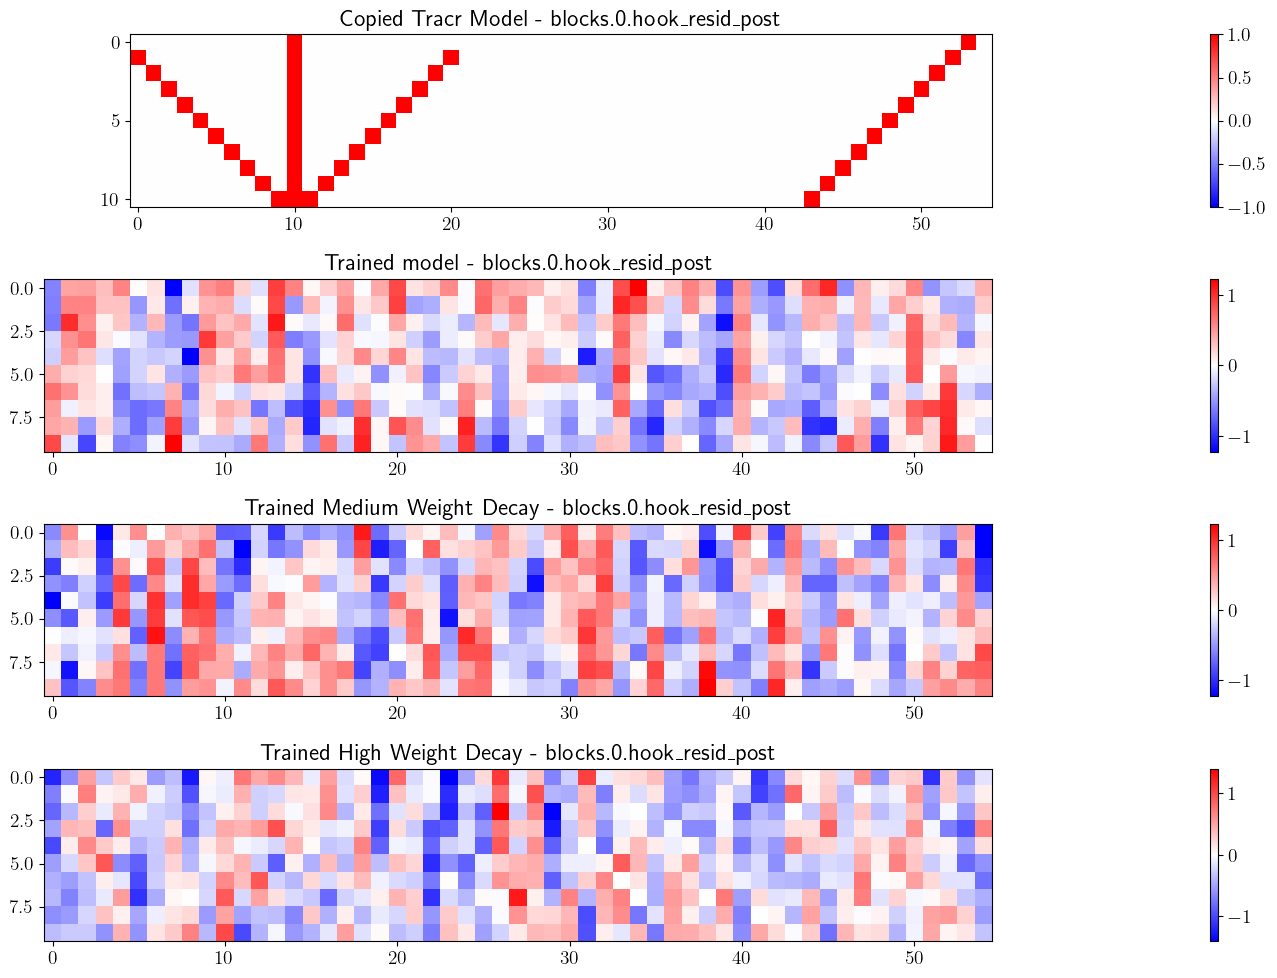

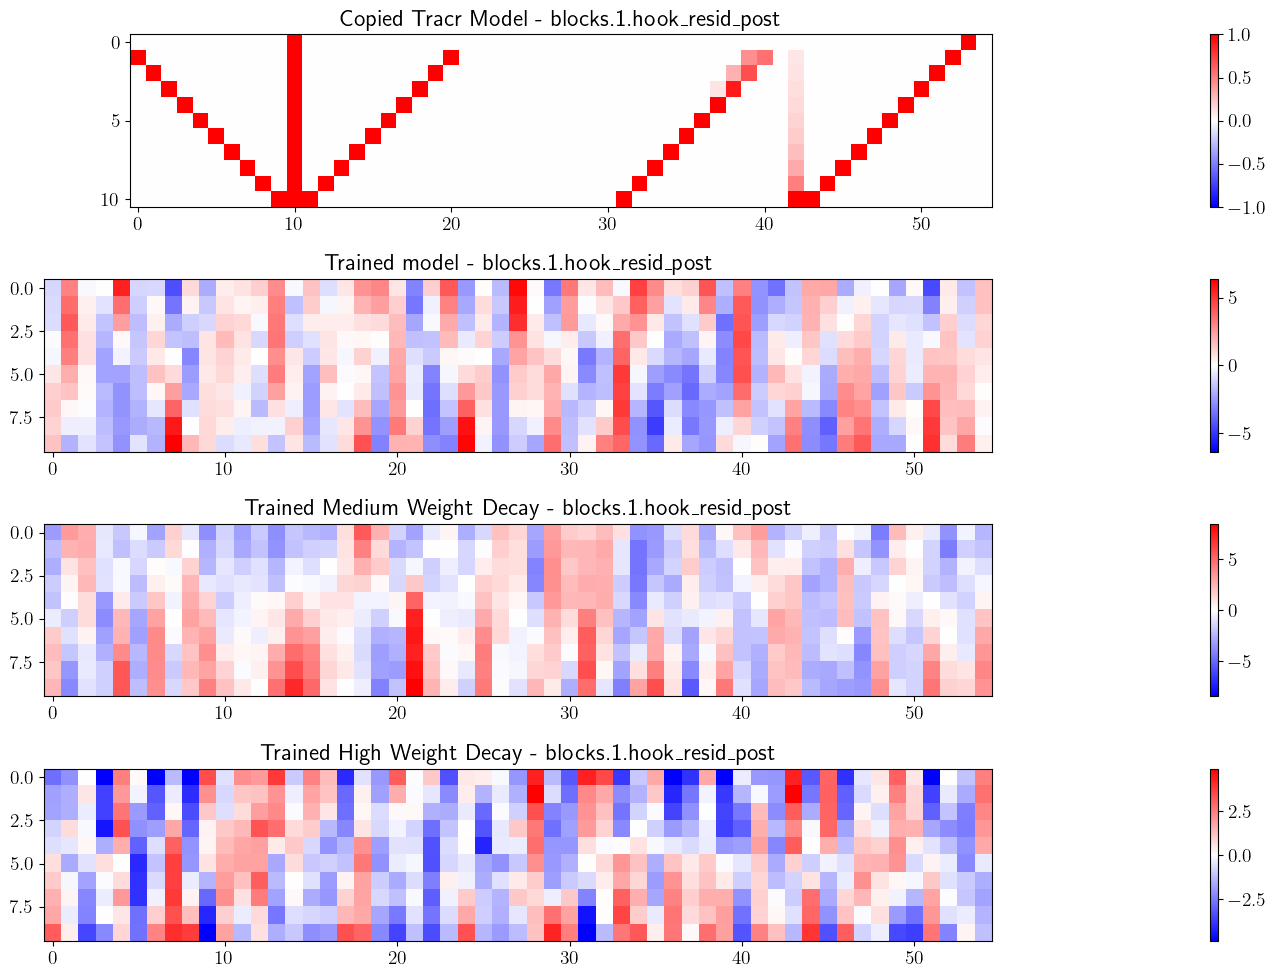

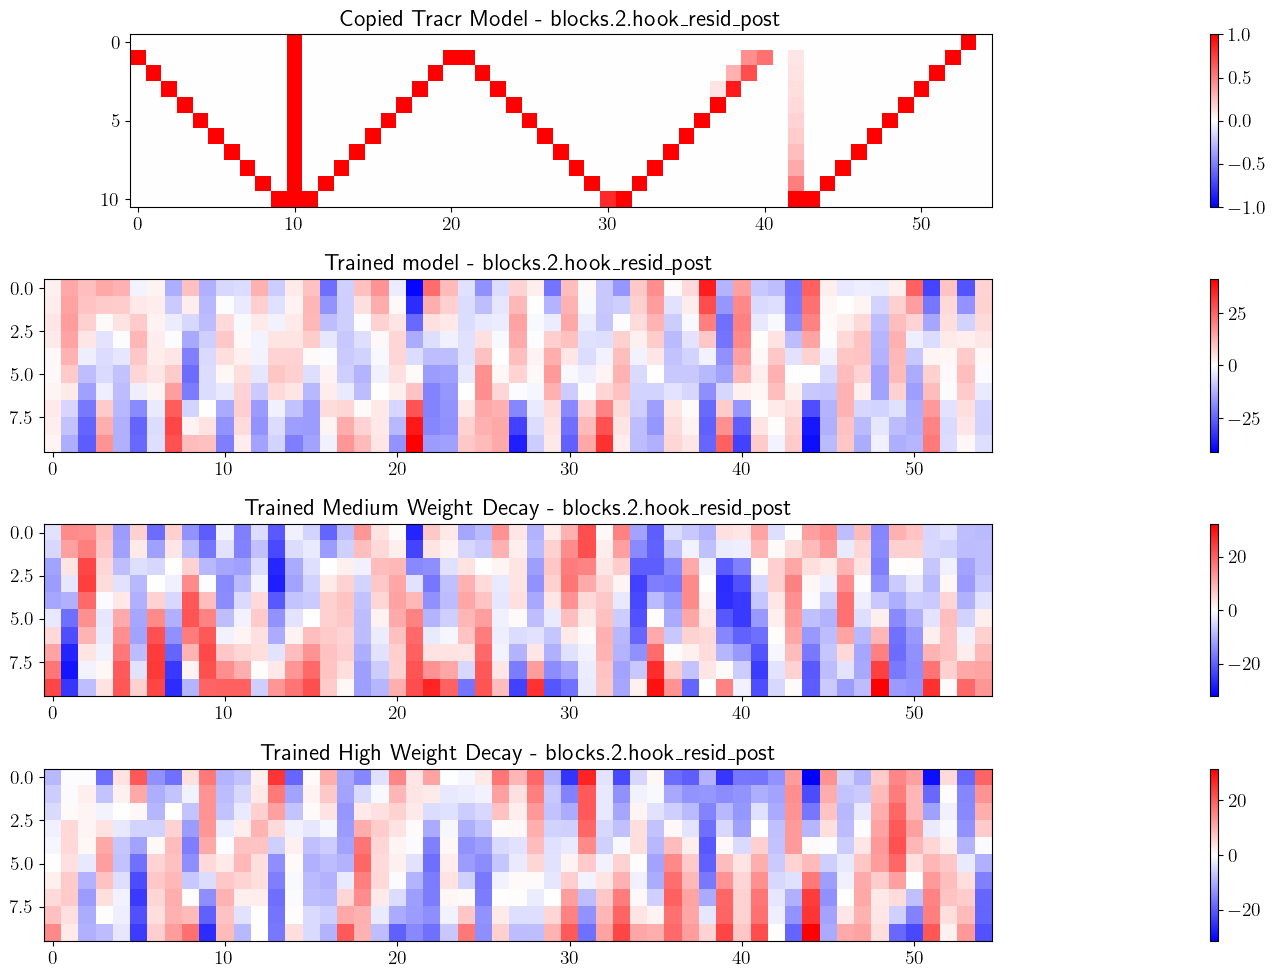

In [15]:
reload_fuctions()
act_caches = [cache.items() for cache in [tracr_cache, trained_cache, trained_mid_decay_cache, trained_high_decay_cache]]
act_zipped = [*zip(*act_caches)]
resid_labels = ['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post']

# Filter activations with the specific name
filtered_activations = [list(filter(lambda x: x[0] in resid_labels, activations)) for activations in act_zipped]
filtered_activations = [activations for activations in filtered_activations if activations]

labels = ["Copied Tracr Model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay"]

for i, activations in enumerate(filtered_activations):
    plot_activations(
        [f"{labels[i]} - {activations[i][0]}" for i in range(len(activations))],
        *[to_numpy(activation[1]) for activation in activations ]
    )
